In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
)

# Import Dataset

In [3]:
df = pd.read_csv('adult.data.csv')

# Preprocessing

## Categorical Dummy Coding

In [4]:
# Identify categorical columns by dtype (object or category); dummy-encode all
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
df_dum = pd.get_dummies(df, columns=cat_cols, drop_first=False)

## 50K Variable

In [5]:
# Target: income_>50K; drop the companion dummy income_<=50K if present
if "income_>50K" not in df_dum.columns:
    raise ValueError("Expected a target column 'income_>50K' after get_dummies. "
                     "Check the input data or column names.")

y = df_dum["income_>50K"].astype(int)
X = df_dum.drop(columns=[c for c in ["income_>50K", "income_<=50K"] if c in df_dum.columns])

## Training and Testing Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=111, stratify=y
)
print(f"Shapes -> X_train: {X_train.shape}, X_test: {X_test.shape}")
print("Class balance (train):")
print(y_train.value_counts(normalize=True).rename({0:"<=50K",1:">50K"}).round(3))


Shapes -> X_train: (26048, 108), X_test: (6513, 108)
Class balance (train):
income_>50K
<=50K    0.759
>50K     0.241
Name: proportion, dtype: float64


## Scaling

In [7]:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# KNN

## KNN = 10


[KNN k=10, uniform] Accuracies
Train: 0.8570 | Test: 0.8334

Classification report (test, k=10):
              precision    recall  f1-score   support

           0     0.8629    0.9280    0.8943      4945
           1     0.7021    0.5351    0.6073      1568

    accuracy                         0.8334      6513
   macro avg     0.7825    0.7315    0.7508      6513
weighted avg     0.8242    0.8334    0.8252      6513



<Figure size 640x480 with 0 Axes>

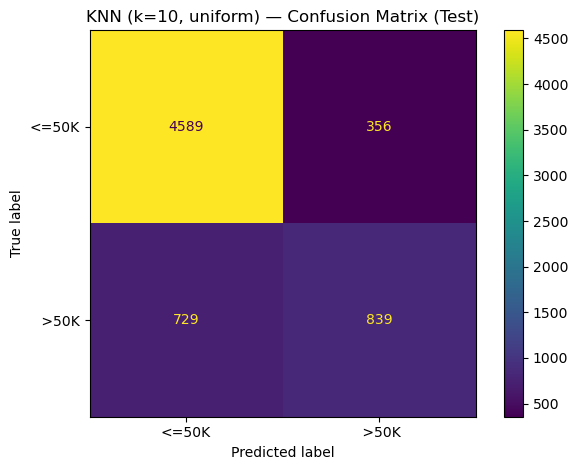

In [8]:
knn10 = KNeighborsClassifier(n_neighbors=10, weights="uniform")
knn10.fit(X_train_s, y_train)

ytr_pred_10 = knn10.predict(X_train_s)
yte_pred_10 = knn10.predict(X_test_s)

acc_tr_10 = accuracy_score(y_train, ytr_pred_10)
acc_te_10 = accuracy_score(y_test, yte_pred_10)
print("\n[KNN k=10, uniform] Accuracies")
print(f"Train: {acc_tr_10:.4f} | Test: {acc_te_10:.4f}")

print("\nClassification report (test, k=10):")
print(classification_report(y_test, yte_pred_10, digits=4))

cm_10 = confusion_matrix(y_test, yte_pred_10)
disp = ConfusionMatrixDisplay(cm_10, display_labels=["<=50K"," >50K"])
fig = plt.figure()
disp.plot(values_format="d")
plt.title("KNN (k=10, uniform) — Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

## Gridsearch

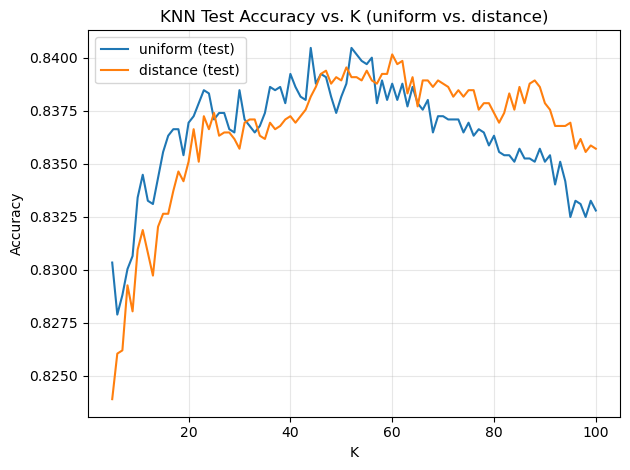


Best KNN (by test accuracy): weights=uniform, K=44, test acc=0.8405
Best-KNN Train acc: 0.8404 | Test acc: 0.8405


In [19]:
# ---------------------------------------------
# b) Sweep K=5..100 and weights∈{uniform, distance}; single plot; pick best
# ---------------------------------------------
Ks = list(range(5, 101))
test_acc_uniform = []
test_acc_distance = []
train_acc_uniform = []
train_acc_distance = []

for k in Ks:
    for w, acc_list_te, acc_list_tr in [
        ("uniform", test_acc_uniform, train_acc_uniform),
        ("distance", test_acc_distance, train_acc_distance),
    ]:
        clf = KNeighborsClassifier(n_neighbors=k, weights=w)
        clf.fit(X_train_s, y_train)
        acc_list_tr.append(clf.score(X_train_s, y_train))
        acc_list_te.append(clf.score(X_test_s, y_test))

# Plot comparison (test accuracy)
plt.figure()
plt.plot(Ks, test_acc_uniform, label="uniform (test)")
plt.plot(Ks, test_acc_distance, label="distance (test)")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("KNN Test Accuracy vs. K (uniform vs. distance)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Choose best by highest test accuracy; break ties by larger K (often smoother)
best_uniform_idx = int(np.argmax(test_acc_uniform))
best_distance_idx = int(np.argmax(test_acc_distance))

cand = [
    ("uniform", Ks[best_uniform_idx], test_acc_uniform[best_uniform_idx]),
    ("distance", Ks[best_distance_idx], test_acc_distance[best_distance_idx]),
]
best_weight, best_k, best_acc = max(cand, key=lambda t: t[2])

print(f"\nBest KNN (by test accuracy): weights={best_weight}, K={best_k}, test acc={best_acc:.4f}")

knn_best = KNeighborsClassifier(n_neighbors=best_k, weights=best_weight)
knn_best.fit(X_train_s, y_train)
acc_tr_best = knn_best.score(X_train_s, y_train)
acc_te_best = knn_best.score(X_test_s, y_test)
print(f"Best-KNN Train acc: {acc_tr_best:.4f} | Test acc: {acc_te_best:.4f}")

## Uniform Only

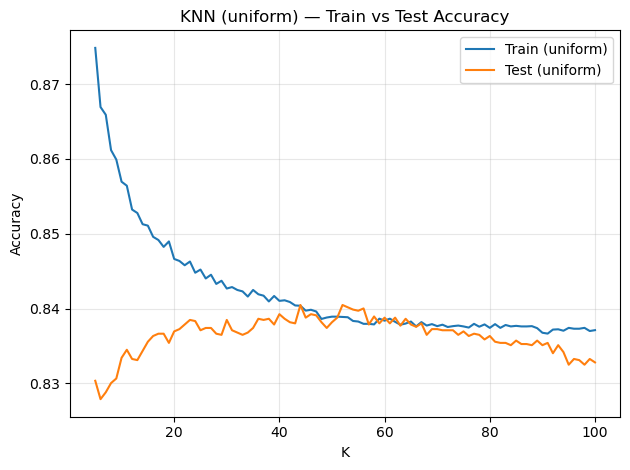

Largest train–test gap (uniform) observed around K=5. Small K (e.g., ~5–15) typically indicates overfitting on this curve.


In [20]:
plt.figure()
plt.plot(Ks, train_acc_uniform, label="Train (uniform)")
plt.plot(Ks, test_acc_uniform, label="Test (uniform)")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("KNN (uniform) — Train vs Test Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Heuristic overfitting range: where Train-Test gap is largest at small K
gaps = np.array(train_acc_uniform) - np.array(test_acc_uniform)
max_gap_k = Ks[int(np.argmax(gaps))]
print(f"Largest train–test gap (uniform) observed around K={max_gap_k}. "
      "Small K (e.g., ~5–15) typically indicates overfitting on this curve.")

# Decision Tree

## Accuracy vs Depth

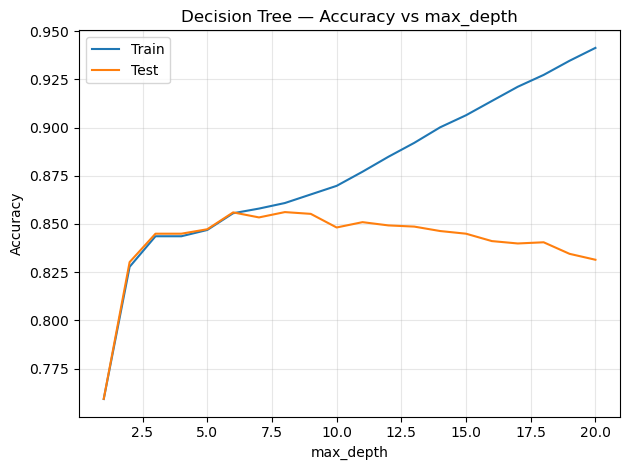

Interpretation tip: rising train acc with falling/flat test acc at larger depths → overfitting; both low → underfitting.


In [11]:
def metrics_from_cm(cm):
    # Binary confusion matrix with labels [0,1] -> rows: true, cols: pred
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / cm.sum()
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan  # recall for positive (>50K)
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan  # recall for negative (<=50K)
    return acc, sens, spec

def eval_and_report(model, Xtr, ytr, Xte, yte, title_prefix):
    model.fit(Xtr, ytr)
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)
    acc_tr = accuracy_score(ytr, ytr_pred)
    acc_te = accuracy_score(yte, yte_pred)
    print(f"\n[{title_prefix}] Train acc: {acc_tr:.4f} | Test acc: {acc_te:.4f}")
    cm = confusion_matrix(yte, yte_pred, labels=[0,1])
    acc, sens, spec = metrics_from_cm(cm)
    print(f"[{title_prefix}] Test metrics -> Accuracy: {acc:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}")
    disp = ConfusionMatrixDisplay(cm, display_labels=["<=50K"," >50K"])
    disp.plot(values_format="d")
    plt.title(f"{title_prefix} — Confusion Matrix (Test)")
    plt.tight_layout()
    plt.show()
    return acc_tr, acc_te, cm, (acc, sens, spec)

# ----------------------------------------------------------
# Decision Tree
# a) Accuracy vs max_depth (over/underfitting view)
# ----------------------------------------------------------
depths = list(range(1, 21))
dt_train_acc = []
dt_test_acc = []

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=111)
    dt.fit(X_train, y_train)  # trees don't need scaling
    dt_train_acc.append(dt.score(X_train, y_train))
    dt_test_acc.append(dt.score(X_test, y_test))

plt.figure()
plt.plot(depths, dt_train_acc, label="Train")
plt.plot(depths, dt_test_acc, label="Test")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree — Accuracy vs max_depth")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Interpretation tip: rising train acc with falling/flat test acc at larger depths → overfitting; "
      "both low → underfitting.")


## 10-Fold CV

In [12]:
# ----------------------------------------------------------
# b) 10-fold CV for max_depth & min_samples_split
#    i) min_samples_split: 5..60 step 5
#    ii) max_depth: 1..15 step 2
# ----------------------------------------------------------
param_grid = {
    "max_depth": list(range(1, 16, 2)),
    "min_samples_split": list(range(5, 61, 5))
}
dt_base = DecisionTreeClassifier(random_state=111)
grid = GridSearchCV(
    dt_base, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1
)
grid.fit(X_train, y_train)
print("\n[Decision Tree CV] Best params:", grid.best_params_)
print("[Decision Tree CV] Mean CV accuracy:", f"{grid.best_score_:.4f}")



[Decision Tree CV] Best params: {'max_depth': 11, 'min_samples_split': 30}
[Decision Tree CV] Mean CV accuracy: 0.8544


## Best Decision Tree


[Decision Tree (best CV)] Train acc: 0.8700 | Test acc: 0.8535
[Decision Tree (best CV)] Test metrics -> Accuracy: 0.8535, Sensitivity: 0.5504, Specificity: 0.9496


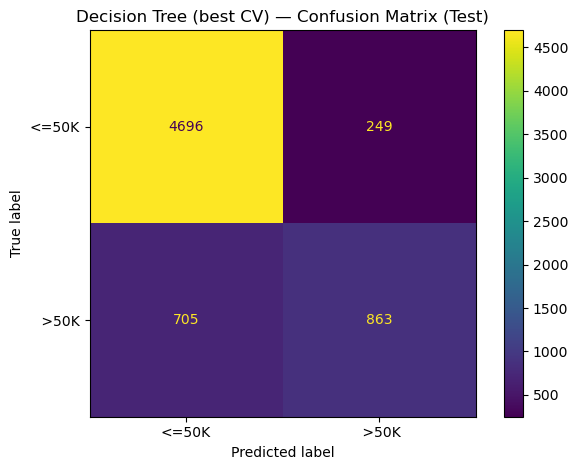

In [13]:
# c-d-e-f) Fit best DT, evaluate, confusion matrix, accuracy/sensitivity/specificity
dt_best = DecisionTreeClassifier(**grid.best_params_, random_state=111)
dt_tr_acc, dt_te_acc, dt_cm, dt_metrics = eval_and_report(
    dt_best, X_train, y_train, X_test, y_test, "Decision Tree (best CV)"
)

## Imbalance Check

In [14]:
print("\nClass distribution (full):")
print(y.value_counts().rename({0:"<=50K",1:">50K"}))
imbalance_ratio = y.value_counts(normalize=True).min()
if imbalance_ratio < 0.4:
    print("Dataset appears imbalanced. Consider reporting: precision/recall, F1, ROC AUC, PR AUC, and balanced accuracy.")
else:
    print("Dataset not strongly imbalanced by conventional thresholds.")



Class distribution (full):
income_>50K
<=50K    24720
>50K      7841
Name: count, dtype: int64
Dataset appears imbalanced. Consider reporting: precision/recall, F1, ROC AUC, PR AUC, and balanced accuracy.


## Important Features

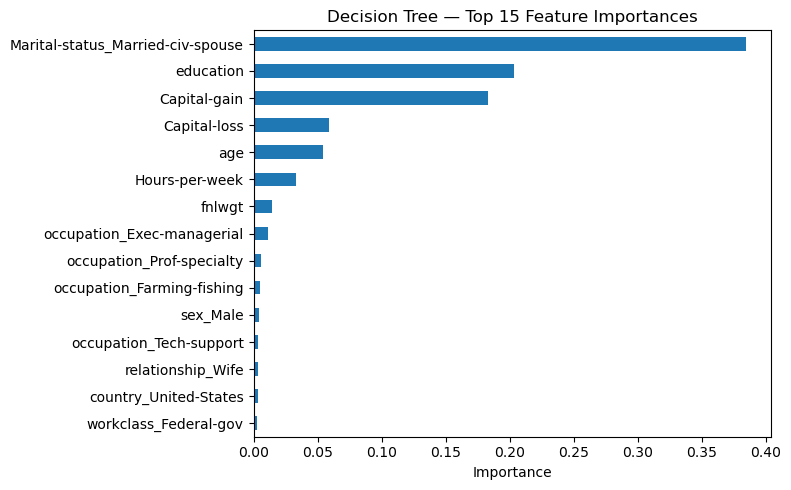

In [15]:

# h) Feature importances (Decision Tree) — top 15
importances_dt = pd.Series(dt_best.feature_importances_, index=X.columns)
top_dt = importances_dt.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
top_dt[::-1].plot(kind="barh")
plt.xlabel("Importance")
plt.title("Decision Tree — Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# Random Forest

## Trees vs Accuracy

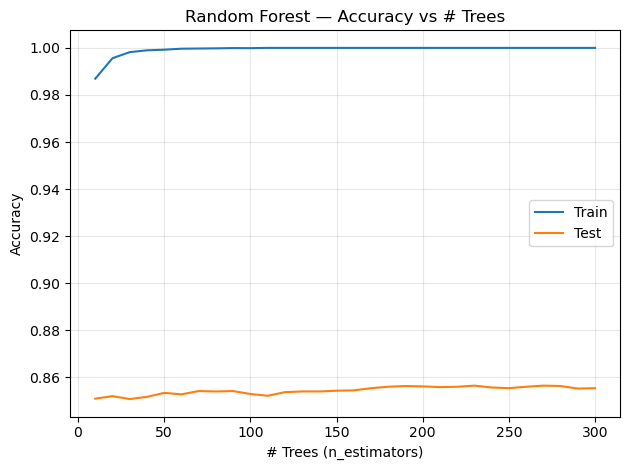

Best #trees by test accuracy: n_estimators=230, test acc=0.8564


In [16]:
trees = list(range(10, 301, 10))
rf_train_acc = []
rf_test_acc = []
for n in trees:
    rf = RandomForestClassifier(
        n_estimators=n, random_state=111, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    rf_train_acc.append(rf.score(X_train, y_train))
    rf_test_acc.append(rf.score(X_test, y_test))

plt.figure()
plt.plot(trees, rf_train_acc, label="Train")
plt.plot(trees, rf_test_acc, label="Test")
plt.xlabel("# Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Random Forest — Accuracy vs # Trees")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_n_idx = int(np.argmax(rf_test_acc))
best_n = trees[best_n_idx]
print(f"Best #trees by test accuracy: n_estimators={best_n}, test acc={rf_test_acc[best_n_idx]:.4f}")


## Best Random Forest


[Random Forest (n=230)] Train acc: 1.0000 | Test acc: 0.8564
[Random Forest (n=230)] Test metrics -> Accuracy: 0.8564, Sensitivity: 0.6384, Specificity: 0.9256


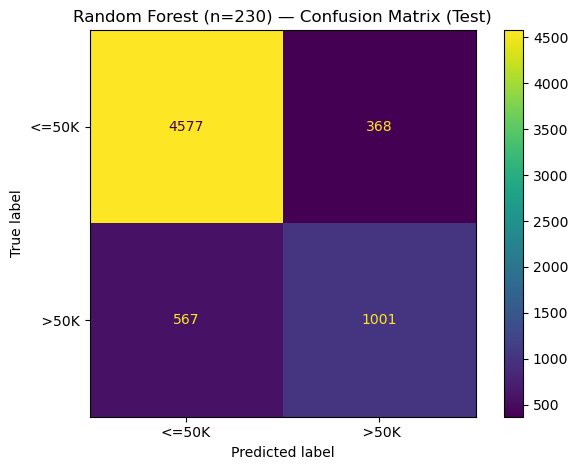

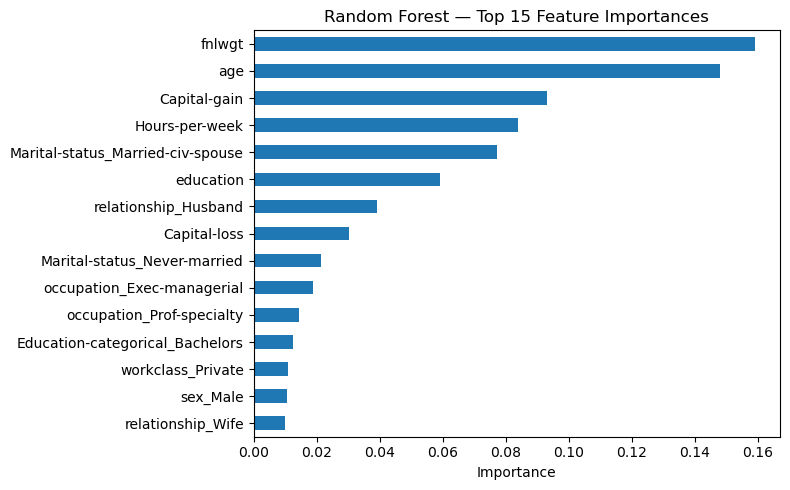

In [17]:
rf_best = RandomForestClassifier(n_estimators=best_n, random_state=111, n_jobs=-1)
rf_tr_acc, rf_te_acc, rf_cm, rf_metrics = eval_and_report(
    rf_best, X_train, y_train, X_test, y_test, f"Random Forest (n={best_n})"
)

importances_rf = pd.Series(rf_best.feature_importances_, index=X.columns)
top_rf = importances_rf.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
top_rf[::-1].plot(kind="barh")
plt.xlabel("Importance")
plt.title("Random Forest — Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# Comparisons

In [21]:
# ----------------------------------------------------------
# (2) Compare the three algorithms
# ----------------------------------------------------------
summary = pd.DataFrame({
    "Model": [
        "KNN (k=10, uniform)",
        f"KNN (best: k={best_k}, w={best_weight})",
        "Decision Tree (CV-tuned)",
        f"Random Forest (n={best_n})",
    ],
    "Train Acc": [acc_tr_10, acc_tr_best, dt_tr_acc, rf_tr_acc],
    "Test Acc":  [acc_te_10, acc_te_best, dt_te_acc, rf_te_acc],
    "Test Acc/Sens/Spec": [
        f"{accuracy_score(y_test, yte_pred_10):.4f}/" +
        f"{metrics_from_cm(confusion_matrix(y_test, yte_pred_10))[1]:.4f}/" +
        f"{metrics_from_cm(confusion_matrix(y_test, yte_pred_10))[2]:.4f}",
        f"{acc_te_best:.4f}/" +
        f"{metrics_from_cm(confusion_matrix(y_test, knn_best.predict(X_test_s)))[1]:.4f}/" +
        f"{metrics_from_cm(confusion_matrix(y_test, knn_best.predict(X_test_s)))[2]:.4f}",
        f"{dt_metrics[0]:.4f}/{dt_metrics[1]:.4f}/{dt_metrics[2]:.4f}",
        f"{rf_metrics[0]:.4f}/{rf_metrics[1]:.4f}/{rf_metrics[2]:.4f}",
    ]
})
print("\n=== Summary: Train/Test Accuracy and Test (Acc/Sens/Spec) ===")
print(summary.to_string(index=False))


=== Summary: Train/Test Accuracy and Test (Acc/Sens/Spec) ===
                      Model  Train Acc  Test Acc   Test Acc/Sens/Spec
        KNN (k=10, uniform)   0.856956  0.833410 0.8334/0.5351/0.9280
KNN (best: k=44, w=uniform)   0.840372  0.840473 0.8405/0.5804/0.9230
   Decision Tree (CV-tuned)   0.870048  0.853524 0.8535/0.5504/0.9496
      Random Forest (n=230)   1.000000  0.856441 0.8564/0.6384/0.9256


# End